In [1]:
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')
from fgc_support_retri.utils import *
from fgc_support_retri import config
from evaluation.eval import eval_sp_fgc, _update_sp

In [3]:
def print_sent_ie(sp_i, d):
    print("sentence{}".format(sp_i))
    print(d['SENTS'][sp_i]['text'])
    for e in d['SENTS'][sp_i]['IE']['NER']:
        print(e)

In [4]:
def eval_from_threshold(data, threshold=0.5):
    all_sp_predictions = []
    all_items = []
    all_answer_sp = []
    for d in tqdm(data):
        for q in d['QUESTIONS']:
            if not q['SHINT']:
                continue
            sp_preds = []
            max_i = 0
            max_score = 0
            assert len(q['sp_scores']) == len(d['SENTS'])
            for sp_i, sp_score in enumerate(q['sp_scores']):
                assert sp_score >= 0
                if sp_score >= threshold:
                    sp_preds.append(sp_i)
                if sp_score > max_score:
                    max_i = sp_i
            if not sp_preds:
                sp_preds.append(max_i)
            q['sp'] = sp_preds
            all_sp_predictions.append(sp_preds)
            all_items.append(q['SHINT'])
            all_answer_sp.append(q['answer_sp'])
    return all_items, all_sp_predictions, all_answer_sp

In [379]:
data = json_load("prediction/entity_revise.json")

In [380]:
len(data)

193

In [381]:
get_SHINT(data)

100%|██████████| 193/193 [00:00<00:00, 11861.86it/s]

{'text': '不具入侵能力但失控繁殖的细胞，称为良性肿瘤', 'start': 492, 'end': 513}
{'text': '牠们会在夜晚成群的爬出洞穴，循著海浪的声音，利用海面光线的导引，快速的爬向大海的家', 'start': 431, 'end': 472}
{'text': '企鹅是生长在极寒冷的冰天雪地里，被称为不会飞的鸟，牠的翅膀像鱼鳍，能跟海豚一般在碧波里游泳，', 'start': 58, 'end': 104}
{'text': '企鹅是生长在极寒冷的冰天雪地里，被称为不会飞的鸟，牠的翅膀像鱼鳍，能跟海豚一般在碧波里游泳，却不能像海鸟一样飞翔在蔚蓝的天空。', 'start': 58, 'end': 121}


In [382]:
get_answer_sp(data, force=True)

100%|██████████| 193/193 [00:00<00:00, 25181.22it/s]


In [464]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(data, threshold=0.00024)

100%|██████████| 193/193 [00:00<00:00, 41214.84it/s]


In [465]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.0, 'sp_prec': 0.114, 'sp_recall': 0.996, 'sp_f1': 0.197}


In [466]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.0, 'sp_prec': 0.074, 'sp_recall': 1.0, 'sp_f1': 0.133}


# len(all_answer_sp)

In [31]:
intervals = []
last = 0
step = 10
for i in range(step):
    now = round(last+1/step, 1)
    intervals.append((last, now))
    last = now

In [32]:
intervals

[(0, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 1.0)]

In [33]:
interv_scores = [0] * 10
interv_scores_tn = [0] * 10
for document in data:
    for question in document['QUESTIONS']:
        gold = question['SHINT']
        for gold_i in gold:
            gold_score = question['sp_scores'][gold_i]
            for interv_i, interv in enumerate(intervals):
                if interv[0] <= gold_score < interv[1]:
                    interv_scores[interv_i] += 1
                    break
        for sent_i, sp_score in enumerate(question['sp_scores']):
            if sent_i not in gold:
                if sent_i not in question['sp']:
                    for interv_i, interv in enumerate(intervals):
                        if interv[0] <= sp_score < interv[1]:
                            interv_scores_tn[interv_i] += 1
                            break

In [34]:
interv_scores

[129, 23, 24, 18, 31, 38, 26, 23, 38, 90]

In [35]:
def createLabels(data):
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )

Text(0.5, 1.0, 'entity score tp')

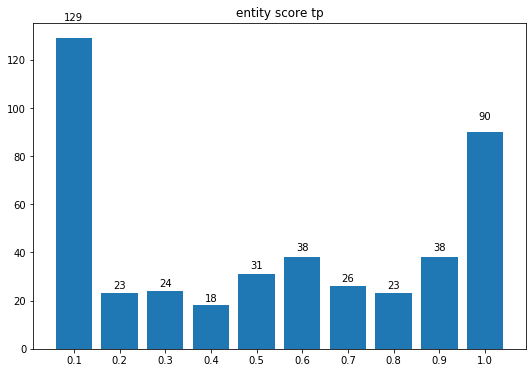

In [36]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores)
createLabels(A)
plt.title('entity score tp')

Text(0.5, 1.0, 'entity score tn')

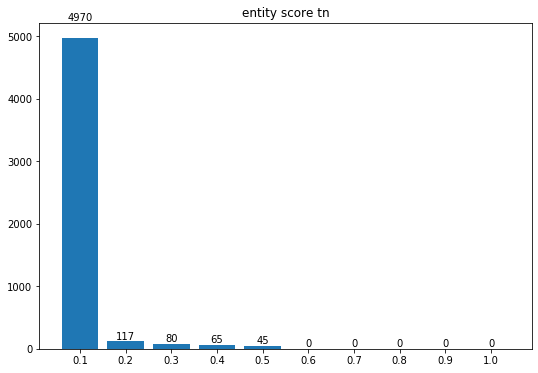

In [37]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_tn)
createLabels(B)
plt.title('entity score tn')

In [38]:
def find_q(qid, data):
    for d in data:
        for q in d['QUESTIONS']:
            if q['QID'] == qid:
                print(q)

In [39]:
def print_analysis_from_qid(qid, data):
    for d in data:
        for q in d['QUESTIONS']:
            if q['QID'] == qid:
                print(q['QID'])
                print(q['QTEXT_CN'])
                print("atype:{}".format(q['ATYPE']))
                print("SHINT:{}".format(q['SHINT']))
                print("sp:{}".format(q['sp']))
                print("answer:{}".format(q['ANSWER']))
                all_set = set(q['SHINT']) | set(q['sp'])
                for sp_i in range(min(all_set), max(all_set) + 1):
                    print_sent_ie(sp_i, d)
                    print()

In [40]:
print_analysis_from_qid('D105Q01', data)

D105Q01
全民健保于哪一年实施?
atype:Date-Duration
SHINT:[0, 1, 36]
sp:[0, 1, 4, 8, 9, 15, 36]
answer:[{'ATEXT': '1995年', 'ATEXT_CN': '1995年', 'ATOKEN': [{'text': '1995年', 'text_cn': '1995年', 'start': 510, 'end': 515}]}]
sentence0
全民健康保险，

sentence1
一般简称为「全民健保」或「健保」，

sentence2
是一种强制性保险的福利政策，
{'id': 'D0-S0-M0', 'string': '一', 'type': 'NUMBER', 'char_b': 1, 'char_e': 2}

sentence3
法源是依据《中华民国宪法增修条文》所实施的全民医疗保险制度。
{'id': 'D0-S0-M0', 'string': '中华民国宪法增修条文', 'type': 'MISC', 'char_b': 6, 'char_e': 16}

sentence4

在全民健康保险实施以前，

sentence5
台湾按照职业别分别实施军人保险（军保）、公教人员保险（公保）、劳工保险（劳保）、农民健康保险（农保），
{'id': 'D0-S0-M0', 'string': '台湾', 'type': 'STATE_OR_PROVINCE', 'char_b': 0, 'char_e': 2}
{'id': 'D0-S0-M1', 'string': '公保', 'type': 'PER', 'char_b': 27, 'char_e': 29}
{'id': 'D0-S0-M2', 'string': '农民', 'type': 'TITLE', 'char_b': 40, 'char_e': 42}

sentence6
并有保险业各自承保的健康保险。

sentence7
 1986年5月，
{'id': 'D0-S0-M0', 'string': '1986年5月', 'type': 'DATE', 'char_b': 1, 'char_e': 8}

sentence8
行政院核定的「中华民国台湾经济长期展望」中提到以2000年为全民健保

In [41]:
find_q('D033Q04', data)

{'QID': 'D033Q04', 'QTYPE': '進階題', 'ATYPE': 'Object', 'AMODE': ['Single-Span-Extraction'], 'QTEXT': '「北美自由貿易協議2.0」的法文簡稱為何?', 'QTEXT_CN': '「北美自由贸易协议2.0」的法文简称为何?', 'SENTS': [{'text': '「北美自由贸易协议2.0」的法文简称为何?', 'start': 0, 'end': 21, 'IE': {'NER': [{'id': 'D0-S0-M0', 'string': '北美', 'type': 'LOC', 'char_b': 1, 'char_e': 3}, {'id': 'D0-S0-M1', 'string': '2.0', 'type': 'NUMBER', 'char_b': 9, 'char_e': 12}, {'id': 'D0-S0-M2', 'string': '法文', 'type': 'DEMONYM', 'char_b': 14, 'char_e': 16}], 'COREF': {}, 'RELATION': [], 'TOKEN': [{'word': '「', 'char_b': 0, 'char_e': 1, 'pos': 'PU'}, {'word': '北美', 'char_b': 1, 'char_e': 3, 'pos': 'NR'}, {'word': '自由', 'char_b': 3, 'char_e': 5, 'pos': 'JJ'}, {'word': '贸易', 'char_b': 5, 'char_e': 7, 'pos': 'NN'}, {'word': '协议', 'char_b': 7, 'char_e': 9, 'pos': 'NN'}, {'word': '2.0', 'char_b': 9, 'char_e': 12, 'pos': 'CD'}, {'word': '」', 'char_b': 12, 'char_e': 13, 'pos': 'PU'}, {'word': '的', 'char_b': 13, 'char_e': 14, 'pos': 'DEC'}, {'word': '法文', 'char_b': 14, '

In [42]:
data[100]

{'DID': 'D201',
 'QUESTIONS': [{'QID': 'D201Q02',
   'QTYPE': '進階題',
   'ATYPE': 'YesNo',
   'AMODE': ['YesNo'],
   'QTEXT': '內政部所發布的新聞稿是否享有著作權?',
   'QTEXT_CN': '内政部所发布的新闻稿是否享有著作权?',
   'SENTS': [{'text': '内政部所发布的新闻稿是否享有著作权?',
     'start': 0,
     'end': 18,
     'IE': {'NER': [{'id': 'D0-S0-M0',
        'string': '内政部',
        'type': 'LOC',
        'char_b': 0,
        'char_e': 3}],
      'COREF': {},
      'RELATION': [],
      'TOKEN': [{'word': '内政部', 'char_b': 0, 'char_e': 3, 'pos': 'NN'},
       {'word': '所', 'char_b': 3, 'char_e': 4, 'pos': 'MSP'},
       {'word': '发布', 'char_b': 4, 'char_e': 6, 'pos': 'VV'},
       {'word': '的', 'char_b': 6, 'char_e': 7, 'pos': 'DEC'},
       {'word': '新闻稿', 'char_b': 7, 'char_e': 10, 'pos': 'NN'},
       {'word': '是否', 'char_b': 10, 'char_e': 12, 'pos': 'AD'},
       {'word': '享有', 'char_b': 12, 'char_e': 14, 'pos': 'VV'},
       {'word': '著作权', 'char_b': 14, 'char_e': 17, 'pos': 'NN'},
       {'word': '?', 'char_b': 17, 'char_e': 18, 'po

In [44]:
d = data[100]
for q in d['QUESTIONS']:
    print(q['QID'])
    print(q['QTEXT_CN'])
    print("atype:{}".format(q['ATYPE']))
    print("SHINT:{}".format(q['SHINT']))
    print("answer_sp:{}".format(q['answer_sp']))
    print("sp:{}".format(q['sp']))
    print()
    all_set = set(q['SHINT']) | set(q['sp'])
    for sp_i in range(min(all_set), max(all_set) + 1):
        print(q['sp_scores'][sp_i])
        print_sent_ie(sp_i, d)
        print()

D201Q02
内政部所发布的新闻稿是否享有著作权?
atype:YesNo
SHINT:[7, 8, 13]
answer_sp:[7, 8, 13]
sp:[13]

0.4212956428527832
sentence7
不在此限。
第九条下列各款不得为著作权之标的，
{'id': 'D0-S1-M0', 'string': '第九', 'type': 'ORDINAL', 'char_b': 6, 'char_e': 8}

0.0009019454591907561
sentence8
依宪法、法律命令或公文。

0.0009157869499176741
sentence9
二、中央或地方机关就钱款著作做成之翻译误或编辑误。
{'id': 'D0-S0-M0', 'string': '二', 'type': 'NUMBER', 'char_b': 0, 'char_e': 1}
{'id': 'D0-S0-M1', 'string': '编辑', 'type': 'TITLE', 'char_b': 21, 'char_e': 23}

0.004877206403762102
sentence10

三标语及通用之符号名词、公视术表表格不测或实力是单纯为传达事实之新闻报导所作成之语文著作。
{'id': 'D0-S0-M0', 'string': '三', 'type': 'NUMBER', 'char_b': 1, 'char_e': 2}
{'id': 'D0-S0-M1', 'string': '公视', 'type': 'ORG', 'char_b': 13, 'char_e': 15}

1.6491192582179792e-05
sentence11

依法令举行之各类考试试题积习备用实体。

0.011016324162483215
sentence12

前项第一款所称公文，
{'id': 'D0-S0-M0', 'string': '第一', 'type': 'ORDINAL', 'char_b': 3, 'char_e': 5}

0.003767505520954728
sentence13
包括公务员于职务上草拟之文告、讲稿、新闻稿及其他文书。
{'id': 'D0-S0-M0', 'string': '公务员', 'typ